In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn import metrics

# Preparing dataset

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
raw_df = load_dataset('../../databases/Tcritical.csv')
raw_df = raw_df.drop(['file', 'macro'], axis=1)
#raw_df.head()

In [4]:
df = raw_df.copy()

'''
Variables
C, C**2, C*Mn, C*Si, C*Cr, C*Ni, 
Mn, Mn**2, Mn*Si, Mn*Cr, Mn*Ni, 
Si, Si*Si, Si*Cr, Si*Ni, 
Cr, Cr**2, Cr*Ni,
Ni, Ni**2]
'''

df['C2'] = df['C'].apply(lambda x: x**2)
df['CMn'] = df['C'] * df['Mn']
df['CSi'] = df['C'] * df['Si']
df['CCr'] = df['C'] * df['Cr']
df['CNi'] = df['C'] * df['Ni']
df['Mn2'] = df['Mn'].apply(lambda x: x**2)
df['MnSi'] = df['Si'] * df['Mn']
df['MnCr'] = df['Cr'] * df['Mn']
df['MnNi'] = df['Ni'] * df['Mn']
df['Si'] = df['Si'].apply(lambda x: x**2)
df['SiCr'] = df['Cr'] * df['Si']
df['SiNi'] = df['Si'] * df['Ni']
df['Cr2'] = df['Cr'].apply(lambda x: x**2)
df['CrNi'] = df['Cr'] * df['Ni']
df['Ni2'] = df['Ni'].apply(lambda x: x**2)

df.head()

,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid,C2,...,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
0,0.0,0.0001,1.000000e-08,0.0001,0.000100,NaN,NaN,911.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-12,1.000000e-12,1.000000e-08,1.000000e-08,1.000000e-08
1,0.0,0.0001,1.000000e-08,0.0001,0.750075,NaN,NaN,880.26,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,7.500750e-05,1.000000e-12,7.500750e-09,1.000000e-08,7.500750e-05,5.626125e-01
2,0.0,0.0001,1.000000e-08,0.0001,1.500050,NaN,NaN,853.25,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,1.500050e-04,1.000000e-12,1.500050e-08,1.000000e-08,1.500050e-04,2.250150e+00
3,0.0,0.0001,1.000000e-08,0.0001,2.250025,NaN,NaN,829.60,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,2.250025e-04,1.000000e-12,2.250025e-08,1.000000e-08,2.250025e-04,5.062613e+00
4,0.0,0.0001,1.000000e-08,0.0001,3.000000,NaN,NaN,808.65,hipo,0.0,...,0.0,1.000000e-08,1.000000e-08,1.000000e-08,3.000000e-04,1.000000e-12,3.000000e-08,1.000000e-08,3.000000e-04,9.000000e+00


# Preparing A1' dataset

In [5]:
df1 = df.copy()
df1 = df.drop(['A3', 'A1'], axis=1)
is_na = df1['A1prime'].isna() 
df1 = df1.loc[~is_na, :] #REMOVE ALL A1 NAN
df1_ = df1.copy()
df1_['eutec'] = (df1_['eutectoid'].map(lambda x: 1 if x == 'hiper' else 0))
df1_ = df1_.drop(['eutectoid'], axis=1) #REMOVE EUTECTOID COLLUMN BECAUSE IT'S A STRING
#df1_

In [6]:
df1_['eutec'].value_counts()
#1 = hipereutectoid
#0 = hipoeutectoid

1    4339
0    1643
Name: eutec, dtype: int64

In [7]:
df1_.head()

,C,Mn,Si,Cr,Ni,A1prime,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
625,0.15,0.0001,1.000000e-08,0.0001,0.000100,726.633,0.0225,0.000015,0.000015,0.000015,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-12,1.000000e-12,1.000000e-08,1.000000e-08,1.000000e-08,0
626,0.15,0.0001,1.000000e-08,0.0001,0.750075,713.041,0.0225,0.000015,0.000015,0.000015,...,1.000000e-08,1.000000e-08,1.000000e-08,7.500750e-05,1.000000e-12,7.500750e-09,1.000000e-08,7.500750e-05,5.626125e-01,0
627,0.15,0.0001,1.000000e-08,0.0001,1.500050,699.260,0.0225,0.000015,0.000015,0.000015,...,1.000000e-08,1.000000e-08,1.000000e-08,1.500050e-04,1.000000e-12,1.500050e-08,1.000000e-08,1.500050e-04,2.250150e+00,0
628,0.15,0.0001,1.000000e-08,0.0001,2.250025,685.552,0.0225,0.000015,0.000015,0.000015,...,1.000000e-08,1.000000e-08,1.000000e-08,2.250025e-04,1.000000e-12,2.250025e-08,1.000000e-08,2.250025e-04,5.062613e+00,0
629,0.15,0.0001,1.000000e-08,0.0001,3.000000,672.221,0.0225,0.000015,0.000015,0.000015,...,1.000000e-08,1.000000e-08,1.000000e-08,3.000000e-04,1.000000e-12,3.000000e-08,1.000000e-08,3.000000e-04,9.000000e+00,0


In [8]:
hiper = df1_['eutec'] == 1
hipo = df1_['eutec'] == 0

df_hiper = df1_.loc[hiper, :]
df_hipo = df1_.loc[hipo, :]

In [9]:
df_hiper.shape

(4339, 21)

In [10]:
df_hipo.shape

(1643, 21)

# A1' Regression

In [11]:
def _split_between_train_and_test(df, size):
    #train size may be 0.8, 0.7 or 0.99
    target = df['A1prime']
    features = df.iloc[:, :20]
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        train_size=size,
        random_state=42
    )
    
    X_train = X_train.drop(['A1prime'], axis=1)
    X_test = X_test.drop(['A1prime'], axis=1)
    
    print('Train size: {}'.format(X_train.shape))
    print('Test size: {}'.format(X_test.shape))
    return X_train, X_test, y_train, y_test

## Hipereutectoid

In [12]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df_hiper, 0.8)

Train size: (3471, 19)
Test size: (868, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
2287,0.45,2.250025,0.562613,1.50005,1.500050,0.2025,1.012511,0.337534,0.675022,0.675022,5.062613e+00,1.687688,3.375150,3.375150e+00,0.843947,0.843947,2.250150e+00,2.250150,2.250150e+00
3235,0.75,0.000100,9.000000,1.50005,0.000100,0.5625,0.000075,2.250000,1.125037,0.000075,1.000000e-08,0.000300,0.000150,1.000000e-08,13.500450,0.000900,2.250150e+00,0.000150,1.000000e-08
4461,1.05,0.000100,5.062613,1.50005,0.750075,1.1025,0.000105,2.362526,1.575052,0.787579,1.000000e-08,0.000225,0.000150,7.500750e-05,7.594172,3.797339,2.250150e+00,1.125150,5.626125e-01
3296,0.75,0.750075,0.562613,3.00000,0.750075,0.5625,0.562556,0.562556,2.250000,0.562556,5.626125e-01,0.562613,2.250225,5.626125e-01,1.687838,0.422002,9.000000e+00,2.250225,5.626125e-01
6777,1.50,3.000000,0.562613,0.00010,1.500050,2.2500,4.500000,1.125112,0.000150,2.250075,9.000000e+00,2.250225,0.000300,4.500150e+00,0.000056,0.843947,1.000000e-08,0.000150,2.250150e+00


In [14]:
y_test.head()

6512    706.281
3781    743.560
5199    729.550
1574    730.540
4044    708.972
Name: A1prime, dtype: float64

In [15]:
y_train.head()

2287    718.967
3235    817.730
4461    785.390
3296    752.430
6777    699.755
Name: A1prime, dtype: float64

In [16]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

753.6549526120252

In [17]:
list(zip(X_test.keys(), model.coef_))

[('C', -24.416955239138147),
 ('Mn', -12.865436436987917),
 ('Si', 4.649427856475851),
 ('Cr', 12.816993102541353),
 ('Ni', -10.075622965616523),
 ('C2', 5.994638337513171),
 ('CMn', 2.241343991622389),
 ('CSi', 9.812705163691138),
 ('CCr', -3.502256357571804),
 ('CNi', -1.6750145677924388),
 ('Mn2', 0.1680125619079238),
 ('MnSi', -1.476995004189296),
 ('MnCr', -0.7850590380589635),
 ('MnNi', 0.4814002115770988),
 ('SiCr', 0.06835106813771219),
 ('SiNi', -0.4009927460785456),
 ('Cr2', -0.5305237148628894),
 ('CrNi', -0.61316048840298),
 ('Ni2', 0.09240001582552448)]

In [18]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

### The line / model

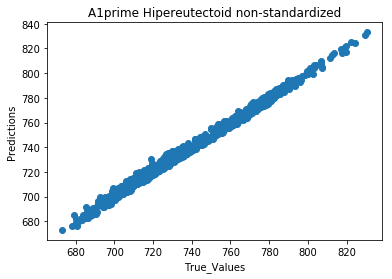

In [19]:
plt.scatter(y_test, predictions)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1prime Hipereutectoid non-standardized')
plt.show()

In [20]:
metrics.r2_score(y_test, predictions)

0.9934436868975275

In [21]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

2.4669236614006294

## Hipoeutectoid

In [22]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df_hipo, 0.8)

Train size: (1314, 19)
Test size: (329, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
1450,0.30,0.750075,5.062613,0.000100,0.000100,0.0900,0.225022,0.675007,0.000030,0.000030,5.626125e-01,1.687688,7.500750e-05,7.500750e-05,0.000506,0.000506,1.000000e-08,1.000000e-08,1.000000e-08
2077,0.45,0.750075,5.062613,0.000100,1.500050,0.2025,0.337534,1.012511,0.000045,0.675022,5.626125e-01,1.687688,7.500750e-05,1.125150e+00,0.000506,7.594172,1.000000e-08,1.500050e-04,2.250150e+00
1709,0.30,2.250025,5.062613,0.750075,3.000000,0.0900,0.675007,0.675007,0.225022,0.900000,5.062613e+00,5.062613,1.687688e+00,6.750075e+00,3.797339,15.187838,5.626125e-01,2.250225e+00,9.000000e+00
1838,0.30,3.000000,5.062613,1.500050,2.250025,0.0900,0.900000,0.675007,0.450015,0.675007,9.000000e+00,6.750075,4.500150e+00,6.750075e+00,7.594172,11.391005,2.250150e+00,3.375150e+00,5.062613e+00
1350,0.30,0.000100,9.000000,0.000100,0.000100,0.0900,0.000030,0.900000,0.000030,0.000030,1.000000e-08,0.000300,1.000000e-08,1.000000e-08,0.000900,0.000900,1.000000e-08,1.000000e-08,1.000000e-08


In [24]:
y_test.head()

1306    756.050
1775    689.570
2076    749.760
1233    686.194
2225    765.060
Name: A1prime, dtype: float64

In [25]:
y_train.head()

1450    754.590
2077    739.600
1709    704.307
1838    715.578
1350    787.630
Name: A1prime, dtype: float64

In [26]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

689.1687655138876

In [27]:
list(zip(X_test.keys(), model.coef_))

[('C', 256.65884260459745),
 ('Mn', -27.182339675845846),
 ('Si', 3.542103739133628),
 ('Cr', 42.71137744052649),
 ('Ni', -14.561281230961477),
 ('C2', -302.8765594014187),
 ('CMn', 18.334673538978528),
 ('CSi', 20.988732126980615),
 ('CCr', -56.18308771491146),
 ('CNi', -4.289402049054994),
 ('Mn2', 1.0852997215795648),
 ('MnSi', -0.834518784848119),
 ('MnCr', 0.3190480555892541),
 ('MnNi', 1.7433451490331051),
 ('SiCr', 0.17979376333527686),
 ('SiNi', -0.24779304763548216),
 ('Cr2', -4.571017455822069),
 ('CrNi', -1.0247055590785012),
 ('Ni2', 0.40985988460564293)]

In [28]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

### The line / model

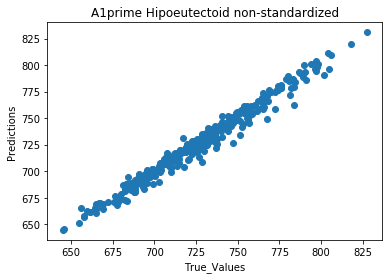

In [29]:
plt.scatter(y_test, predictions)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1prime Hipoeutectoid non-standardized')
plt.show()

In [30]:
metrics.r2_score(y_test, predictions)

0.9743263464131865

In [31]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

5.445118624837604

## Hipo & Hipereutectoid

In [32]:
X_train, X_test, y_train, y_test = _split_between_train_and_test(df1_, 0.8)

Train size: (4785, 19)
Test size: (1197, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [33]:
X_train.head()

,C,Mn,Si,Cr,Ni,C2,CMn,CSi,CCr,CNi,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2
2097,0.45,0.750075,5.062613e+00,3.000000,1.500050,0.2025,0.337534,1.012511,1.350000,0.675022,5.626125e-01,1.687688e+00,2.250225e+00,1.125150,1.518784e+01,7.594172e+00,9.000000e+00,4.500150,2.250150e+00
5995,1.35,1.500050,9.000000e+00,3.000000,0.000100,1.8225,2.025067,4.050000,4.050000,0.000135,2.250150e+00,4.500150e+00,4.500150e+00,0.000150,2.700000e+01,9.000000e-04,9.000000e+00,0.000300,1.000000e-08
1064,0.15,2.250025,2.250150e+00,1.500050,3.000000,0.0225,0.337504,0.225007,0.225007,0.450000,5.062613e+00,3.375150e+00,3.375150e+00,6.750075,3.375338e+00,6.750450e+00,2.250150e+00,4.500150,9.000000e+00
1253,0.30,0.000100,1.000000e-08,0.000100,2.250025,0.0900,0.000030,0.000030,0.000030,0.675007,1.000000e-08,1.000000e-08,1.000000e-08,0.000225,1.000000e-12,2.250025e-08,1.000000e-08,0.000225,5.062613e+00
4307,0.90,3.000000,2.250150e+00,0.750075,1.500050,0.8100,2.700000,1.350045,0.675068,1.350045,9.000000e+00,4.500150e+00,2.250225e+00,4.500150,1.687781e+00,3.375338e+00,5.626125e-01,1.125150,2.250150e+00


In [34]:
y_test.head()

1699    719.060
6359    771.560
6197    721.007
1947    773.170
6848    726.428
Name: A1prime, dtype: float64

In [35]:
y_train.head()

2097    776.170
5995    806.900
1064    688.540
1253    693.955
4307    712.633
Name: A1prime, dtype: float64

In [36]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
model.intercept_

# predictor = LinearRegression(n_jobs=-1, normalize=True)
# estimator = predictor.fit(X_train, y_train)
# estimator.intercept_

722.5158963260731

In [37]:
list(zip(X_test.keys(), model.coef_))

[('C', 36.27203925437317),
 ('Mn', -17.327286306106988),
 ('Si', 4.885406805341597),
 ('Cr', 22.06665833693506),
 ('Ni', -12.819223157903492),
 ('C2', -20.76190458478548),
 ('CMn', 4.45656199781129),
 ('CSi', 9.26864499037676),
 ('CCr', -9.317594535422003),
 ('CNi', -0.40986274079559504),
 ('Mn2', 0.41201930270949644),
 ('MnSi', -1.1786701975334344),
 ('MnCr', -0.5131176132113092),
 ('MnNi', 0.8386209283325776),
 ('SiCr', -0.02503544457947693),
 ('SiNi', -0.3761659917959695),
 ('Cr2', -1.4736325035410658),
 ('CrNi', -0.4441372388721621),
 ('Ni2', 0.22958982940184502)]

In [38]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

### The line / model

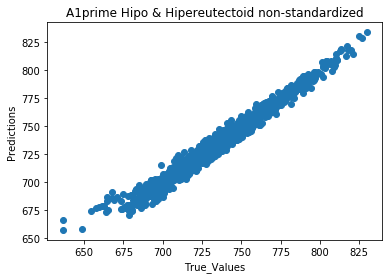

In [39]:
plt.scatter(y_test, predictions)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1prime Hipo & Hipereutectoid non-standardized')
plt.show()

In [40]:
metrics.r2_score(y_test, predictions)

0.9748337026862111

In [41]:
#RMSE
math.sqrt(metrics.mean_squared_error(y_test, predictions))

5.034688253012137

# A1 regression with database standardization

## Hipereutectoid

In [42]:
df2_hiper = df_hiper.copy()
df2_hiper = df2_hiper.loc[~is_na, :]

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_hiper.iloc[:, :-1])
df2_hiper.iloc[:, :-1] = scaler.transform(df2_hiper.iloc[:, :-1])

In [44]:
df2_hiper.head()

,C,Mn,Si,Cr,Ni,A1prime,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
1273,-2.118083,-1.446588,-0.991342,1.322211,0.663576,0.212320,-1.565383,-1.251193,-1.195031,-0.561339,...,-1.053276,-0.893261,-0.952166,-0.924038,-0.728464,-0.715302,1.574783,1.636396,0.462367,1
1274,-2.118083,-1.446588,-0.991342,1.322211,1.371879,-0.103722,-1.565383,-1.251193,-1.195031,-0.561339,...,-1.053276,-0.893261,-0.952166,-0.924009,-0.728464,-0.715302,1.574783,2.501115,1.639164,1
1299,-2.118083,-1.446588,-0.820796,1.322211,1.371879,0.177910,-1.565383,-1.251193,-1.015886,-0.561339,...,-1.053276,-0.893231,-0.952166,-0.924009,-0.494361,-0.478122,1.574783,2.501115,1.639164,1
1398,-2.118083,-0.741256,-0.991342,1.322211,0.663576,-0.131785,-1.565383,-1.068212,-1.195031,-0.561339,...,-0.883811,-0.893231,-0.088184,-0.267650,-0.728464,-0.715302,1.574783,1.636396,0.462367,1
1399,-2.118083,-0.741256,-0.991342,1.322211,1.371879,-0.428751,-1.565383,-1.068212,-1.195031,-0.561339,...,-0.883811,-0.893231,-0.088184,-0.048834,-0.728464,-0.715302,1.574783,2.501115,1.639164,1


In [45]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_hiper, 0.8)

Train size: (3471, 19)
Test size: (868, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [46]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

6.11771351674529e-05

In [47]:
list(zip(X2_test.keys(), model2.coef_))

[('C', -0.27664857183880015),
 ('Mn', -0.45701636498119336),
 ('Si', 0.5124135508322953),
 ('Cr', 0.4495372180440529),
 ('Ni', -0.3564124173045779),
 ('C2', 0.13587184808536762),
 ('CMn', 0.09207139375327518),
 ('CSi', 0.4117237645394521),
 ('CCr', -0.14114347021953413),
 ('CNi', -0.06895237349693056),
 ('Mn2', 0.01863479240856869),
 ('MnSi', -0.12479257811944389),
 ('MnCr', -0.06829980224494005),
 ('MnNi', 0.04134596973601891),
 ('SiCr', 0.016463481681492656),
 ('SiNi', -0.09533296713689565),
 ('Cr2', -0.059646635386646316),
 ('CrNi', -0.053299209905021044),
 ('Ni2', 0.010328377711909413)]

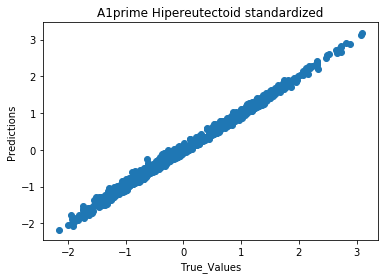

In [48]:
plt.scatter(y2_test, predictions2)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1prime Hipereutectoid standardized')
plt.show()

In [49]:
#R2
metrics.r2_score(y2_test, predictions2)

0.9934436868975275

In [50]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.08241557947452373

## Hipoeutectoid

In [51]:
df2_hipo = df_hipo.copy()
df2_hipo = df2_hipo.loc[~is_na, :]

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_hipo.iloc[:, :-1])
df2_hipo.iloc[:, :-1] = scaler.transform(df2_hipo.iloc[:, :-1])

In [53]:
df2_hipo.head()

,C,Mn,Si,Cr,Ni,A1prime,C2,CMn,CSi,CCr,...,Mn2,MnSi,MnCr,MnNi,SiCr,SiNi,Cr2,CrNi,Ni2,eutec
625,-1.032771,-1.313779,-1.034718,-1.16713,-1.300962,-0.081503,-0.865091,-1.068838,-1.098922,-1.078835,...,-0.94266,-0.859783,-0.757169,-0.811672,-0.65856,-0.691719,-0.829084,-0.750543,-0.933366,0
626,-1.032771,-1.313779,-1.034718,-1.16713,-0.590127,-0.461702,-0.865091,-1.068838,-1.098922,-1.078835,...,-0.94266,-0.859783,-0.757169,-0.811640,-0.65856,-0.691719,-0.829084,-0.750508,-0.758176,0
627,-1.032771,-1.313779,-1.034718,-1.16713,0.120708,-0.847187,-0.865091,-1.068838,-1.098922,-1.078835,...,-0.94266,-0.859783,-0.757169,-0.811607,-0.65856,-0.691719,-0.829084,-0.750472,-0.232699,0
628,-1.032771,-1.313779,-1.034718,-1.16713,0.831543,-1.230631,-0.865091,-1.068838,-1.098922,-1.078835,...,-0.94266,-0.859783,-0.757169,-0.811575,-0.65856,-0.691719,-0.829084,-0.750437,0.643064,0
629,-1.032771,-1.313779,-1.034718,-1.16713,1.542378,-1.603529,-0.865091,-1.068838,-1.098922,-1.078835,...,-0.94266,-0.859783,-0.757169,-0.811543,-0.65856,-0.691719,-0.829084,-0.750402,1.869113,0


In [54]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_hipo, 0.8)

Train size: (1314, 19)
Test size: (329, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [55]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

0.00015156810860245118

In [56]:
list(zip(X2_test.keys(), model2.coef_))

[('C', 1.0243223751482704),
 ('Mn', -0.8025805152025652),
 ('Si', 0.3321666163144043),
 ('Cr', 1.223292764532191),
 ('Ni', -0.42973912162353606),
 ('C2', -0.844921696756852),
 ('CMn', 0.18872079286826704),
 ('CSi', 0.24333994146854465),
 ('CCr', -0.440482186597031),
 ('CNi', -0.04381877586393839),
 ('Mn2', 0.09782253043809815),
 ('MnSi', -0.05696518291334857),
 ('MnCr', 0.01897169941375848),
 ('MnNi', 0.11379722421894894),
 ('SiCr', 0.03287064346238612),
 ('SiNi', -0.04739165297642325),
 ('Cr2', -0.38195994157810403),
 ('CrNi', -0.06069905274958488),
 ('Ni2', 0.036818220301686744)]

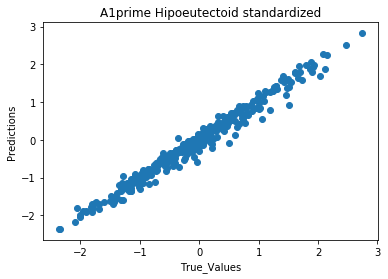

In [57]:
plt.scatter(y2_test, predictions2)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1prime Hipoeutectoid standardized')
plt.show()

In [58]:
#R2
metrics.r2_score(y2_test, predictions2)

0.9743263464131868

In [59]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.1523121586317144

## Hipo & Hipereutectoid

In [60]:
df2_ = df1_.copy()
df2_ = df2_.loc[~is_na, :]

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df2_.iloc[:, :-1])
df2_.iloc[:, :-1] = scaler.transform(df2_.iloc[:, :-1])

In [62]:
X2_train, X2_test, y2_train, y2_test = _split_between_train_and_test(df2_, 0.8)

Train size: (4785, 19)
Test size: (1197, 19)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [63]:
model2 = lm.fit(X2_train, y2_train)
predictions2 = lm.predict(X2_test)
model2.intercept_

-0.0009611679803452511

In [64]:
list(zip(X2_test.keys(), model2.coef_))

[('C', 0.49972107848768355),
 ('Mn', -0.5784270606977662),
 ('Si', 0.5084201961881378),
 ('Cr', 0.7338169831912316),
 ('Ni', -0.42687005748496143),
 ('C2', -0.4848960802178003),
 ('CMn', 0.16525596919968022),
 ('CSi', 0.34540572028694083),
 ('CCr', -0.3462174773066208),
 ('CNi', -0.015262373183953029),
 ('Mn2', 0.042683058661417195),
 ('MnSi', -0.09273214485205834),
 ('MnCr', -0.04046877637953486),
 ('MnNi', 0.06627050744846184),
 ('SiCr', -0.0055363053250839),
 ('SiNi', -0.08317001719453654),
 ('Cr2', -0.15318997054575664),
 ('CrNi', -0.035010782733296976),
 ('Ni2', 0.023912451128990497)]

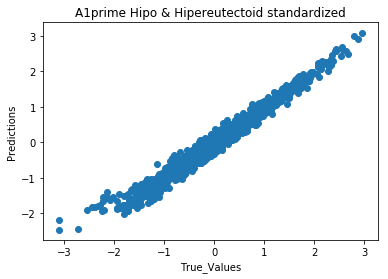

In [65]:
plt.scatter(y2_test, predictions2)
plt.xlabel('True_Values')
plt.ylabel('Predictions')
plt.title('A1prime Hipo & Hipereutectoid standardized')
plt.show()

In [66]:
#R2
metrics.r2_score(y2_test, predictions2)

0.9748337026862112

In [67]:
#RMSE
math.sqrt(metrics.mean_squared_error(y2_test, predictions2))

0.15806172274345648

# Summarizing...

### Non-standardized

|  | Hipo | Hiper | All |
| --- | --- | --- | --- |
| R2 |0.9743|0.9934|0.9748|
| RMSE |5.4451|2.4669|5.0347|

### Standardized

|  | Hipo | Hiper | All |
| --- | --- | --- | --- |
| R2 |0.9743|0.9934|0.9425|
| RMSE |0.1523|0.0824|0.2335|

### Next steps
- other metrics: relative percentage error